## Final Project Submission

Please fill out:
* Student name: Abdulrahman Aber, Benjamin Bai, Charles Pan, Kevin Rivera
* Student pace: Full Time
* Scheduled project review date/time: 
* Instructor name: David Elliott
* Blog post URL:


# Imports

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sq
import seaborn as sns
conn = sq.connect('./zippedData/im.db/im.db')
cur = conn.cursor()

# Load all source files as dataframes

In [3]:
bom_movie_gross_df = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')

In [4]:
movie_basics_df = pd.read_sql('''select * from movie_basics''', conn)

In [5]:
directors_df = pd.read_sql("""select * from directors""",conn)

In [6]:
known_for_df = pd.read_sql("""select * from known_for""",conn)

In [7]:
movie_akas_df = pd.read_sql("""select * from movie_akas""",conn)

In [8]:
movie_ratings_df = pd.read_sql("""select * from movie_ratings""",conn)

In [9]:
persons_df = pd.read_sql("""select * from persons""",conn)

In [10]:
principals_df = pd.read_sql("""select * from principals""",conn)

In [11]:
writers_df = pd.read_sql("""select * from writers""",conn)

In [12]:
rt_movie_info_df = pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')

In [13]:
rt_reviews_df = pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

In [14]:
tmdb_movies_df = pd.read_csv('./zippedData/tmdb.movies.csv.gz')

In [15]:
tn_movie_budgets_df = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz',
                                 parse_dates=['release_date'])

# TN Movie Budgets Clean Up Process

In [16]:
# Remove $ from production_budget, convert to float
tn_movie_budgets_df['production_budget'] = tn_movie_budgets_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from domestic_gross, convert to float
tn_movie_budgets_df['domestic_gross'] = tn_movie_budgets_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# Remove $ from worldwide_gross, convert to float
tn_movie_budgets_df['worldwide_gross'] = tn_movie_budgets_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)

# new column release_year from release_date to filter based on time frame in scope
tn_movie_budgets_df['release_year'] = pd.DatetimeIndex(tn_movie_budgets_df['release_date']).year

# time frame: 2010-Present; SAG definition of theatrical budget: > 2 million
tn_movie_budgets_df = tn_movie_budgets_df[(tn_movie_budgets_df.release_year >= 2010) & (tn_movie_budgets_df.production_budget > 1999999)]

# Merge TN Movie Budgets with IMDB Movie Basics for Genres Analysis

In [17]:
# rename movie_basics column to match tn_movie_budgets
movie_basics_df.rename(columns={"primary_title":"movie"}, inplace = True)

# merge movie_budgets and imdb movie_basics
moviebudgets_moviebasics_df = tn_movie_budgets_df.merge(movie_basics_df, how='inner', on='movie')

# drop columns that are not relevant to Genre analysis
moviebudgets_moviebasics_df.drop(columns = ['id','release_date', 'movie_id', 'original_title', 'runtime_minutes', 'domestic_gross' ],axis=1,inplace=True)

# remove duplicate movies
moviebudgets_moviebasics_df.drop_duplicates(subset='movie', keep='first', inplace=True, ignore_index=False)

# add column for net_return
moviebudgets_moviebasics_df['net_return'] = (moviebudgets_moviebasics_df['worldwide_gross'] - moviebudgets_moviebasics_df['production_budget'])

# add column for ROI as a %
moviebudgets_moviebasics_df['roi_percent'] = ((moviebudgets_moviebasics_df['net_return'] / moviebudgets_moviebasics_df['production_budget'])*100)

# Genres Analysis Visualizations

In [18]:
# genres to list 
moviebudgets_moviebasics_df['genres'] = moviebudgets_moviebasics_df['genres'].str.split(",")
# explode out rows for movies with multiple genres for visualization purposes
moviebudgets_moviebasics_df = moviebudgets_moviebasics_df.explode('genres')
# means grouped by genre
moviebudgets_moviebasics_mean_df = moviebudgets_moviebasics_df.groupby(['genres']).mean().reset_index()

In [172]:
list(moviebudgets_moviebasics_df['genres'].value_counts().head(5).keys())

['Drama', 'Comedy', 'Action', 'Adventure', 'Thriller']

In [185]:
# visualization 1 dataframe
netreturn_vis = moviebudgets_moviebasics_df.dropna()

n_list = list(moviebudgets_moviebasics_df['genres'].value_counts().head(10).keys())

netreturn_vis = netreturn_vis[netreturn_vis['genres'].isin(n_list)]

(array([0.0e+00, 5.0e+07, 1.0e+08, 1.5e+08, 2.0e+08, 2.5e+08, 3.0e+08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

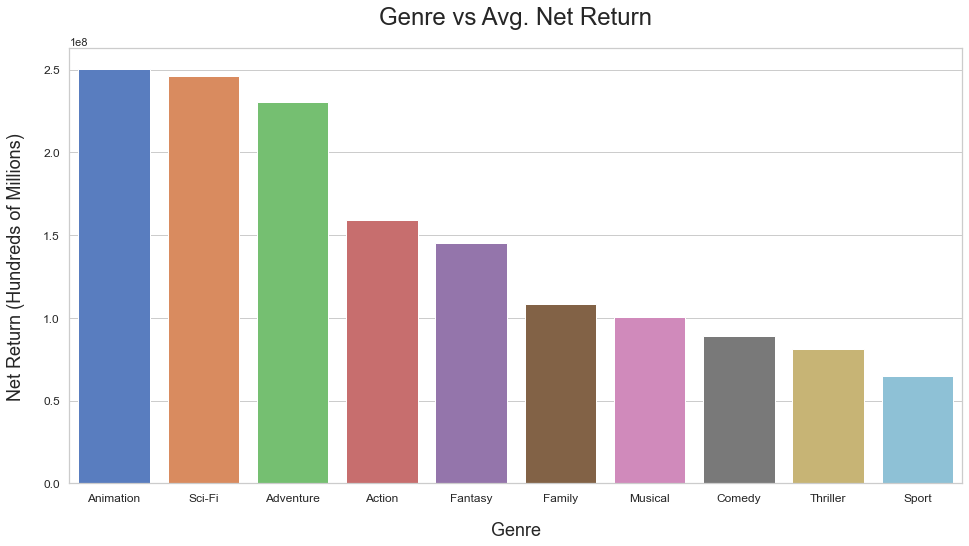

In [202]:
# visualization 1: net return bar

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['net_return'])

net_return_vis = moviebudgets_moviebasics_mean_df.sort_values(by='net_return', ascending=False).head(10)

sns.barplot(x=x_values, y=y_values, data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. Net Return', fontsize = 24, pad=24)
plt.xlabel('Genre', fontsize = 18, labelpad=18)
plt.ylabel('Net Return (Hundreds of Millions)', fontsize = 18, labelpad=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

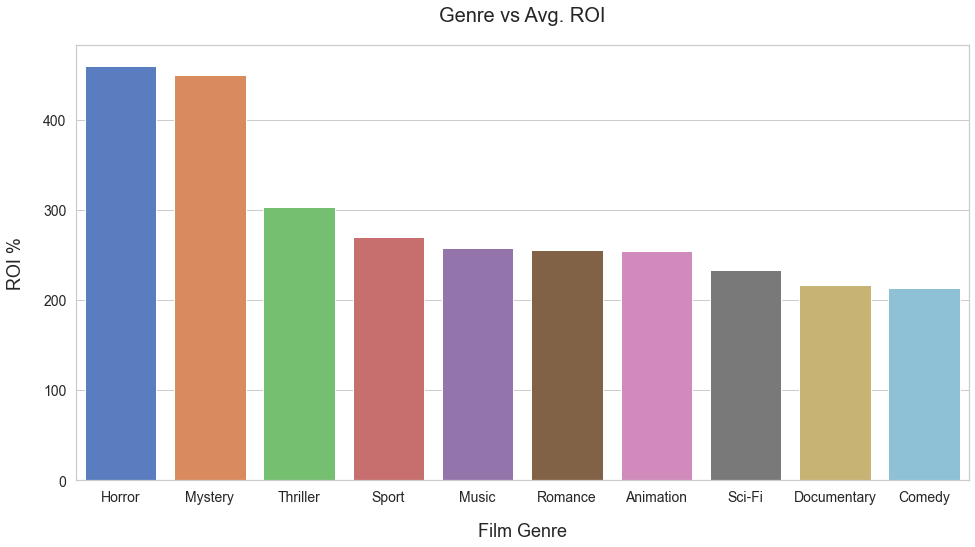

In [201]:
# visualization 2: ROI%

# seaborn style
sns.set(style='whitegrid')

# initialize matlab plot
fig, ax = plt.subplots(figsize=(16, 8))

# define df, x and y values
roi_vis = moviebudgets_moviebasics_mean_df.sort_values(by='roi_percent', ascending=False).head(10)
x_values = list(roi_vis['genres'])
y_values = list(roi_vis['roi_percent'])

# plot
sns.barplot(x=x_values, y=y_values,  data=roi_vis, palette='muted')
ax.set_title('Genre vs Avg. ROI', fontsize = 20, pad=24)
plt.xlabel('Film Genre', fontsize = 18, labelpad=18)
plt.ylabel('ROI %',  fontsize = 18, labelpad=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)